In [1]:
cd ..

/Users/louis.guitton/workspace/dbt-metadata-utils


In [2]:
import json
from collections import deque
from typing import List, Dict, Tuple

from moz_sql_parser import parse, ParseException
import networkx as nx

from dbt_metadata_utils.column_level import LineagePoint, find_col, slice_ctes, process_lineage_point, draw_graph

In [3]:
model_name = "idf_entities"
query = parse("""
with scores_entities as (
    select
        score_type,
        score_id,
        score_name
    from "onefootball"."analytics"."stg_scores__entities"
),
articles as (
    select
        language_code,
        article_id,
        publish_time,
        title
    from
        "onefootball"."analytics_datasets"."train_set_tagging"
),
per_language_count as (
    select
        language_code,
        count(article_id) as per_language_count
    from articles
    group by 1
),
article_entities_counts as (
    select
        language as language_code,
        score_type,
        score_id,
        count(feed_item_id) as per_entity_count
    from "onefootball"."analytics"."stg_cms__feed_item_streams" as fis
    join articles on fis.feed_item_id = articles.article_id
    where
        score_type in ('team', 'competition', 'player')
    group by 1, 2, 3
)
select
    language_code,
    score_type,
    score_id,
    score_name,
    per_language_count,
    per_entity_count,
    log((1 + per_language_count) / (1 + per_entity_count)) + 1 as idf
from article_entities_counts
join per_language_count using (language_code)
join scores_entities using (score_type, score_id)
""")

In [4]:
# model_name = "kg_coaches"
# query = parse("""
# with coaches as (
#     select
#         *
#     from
#         "onefootball"."dbt_louis"."stg_scores__coaches"
#     where
#         team_id != 0
# ),
# teams as (
#     select
#         team_id,
#         favourite_follow_count as team_favourite_follow_count
#     from
#         "onefootball"."dbt_louis"."stg_scores__teams"
#     where
#         favourite_follow_count >= 500
# ),
# coach_translations as (
#     select
#         coach_id,
#         full_name,
#         last_name,
#         language_code
#     from
#         "onefootball"."dbt_louis"."stg_scores__coach_translations"
#     where
#         language_code in ('en', 'fr', 'pt', 'br', 'de', 'es', 'it', 'nl')
#     group by 1, 2, 3, 4
#     -- Ref: https://docs.aws.amazon.com/redshift/latest/dg/c-spectrum-external-performance.html#:~:text=Write%20your%20queries%20to%20use%20filters%20and%20aggregations
# ),
# base_names as (
#     select
#         coach_id,
#         team_id,
#         team_favourite_follow_count,
#         null as language_code,
#         first_name || ' ' || last_name as full_name,
#         last_name
#     from
#         coaches
#         join teams using (team_id)
# ),
# translations_editorial_languages as (
#     select
#         coach_id,
#         team_id,
#         team_favourite_follow_count,
#         language_code,
#         coach_translations.full_name,
#         coach_translations.last_name
#     from
#         coaches
#         join teams using (team_id)
#         join coach_translations using (coach_id)
# ),
# final as (
#     select * from base_names
#     union all
#     select * from translations_editorial_languages
# )
# select distinct
#     *
# from
#     final
# """)

In [5]:
col_of_interest = 'language_code'

nodes: Dict[str, bool] = {}  # dict with bool value which is equal to whether we display the node or not
edges: List[Tuple[str, str]] = []
    
# initialise the deque https://docs.python.org/3/library/collections.html#collections.deque
root = LineagePoint(*find_col(query, col_of_interest), model_name)
nodes[str(root)] = True
to_be_parsed = deque([root])

while len(to_be_parsed):
    lp = to_be_parsed.popleft()
#     print((str(lp), lp.x, lp.y, lp.display_name))
    
    new_lps: List[LineagePoint] = process_lineage_point(lp, query)
    if new_lps is None:
        nodes[str(lp)] = False
    else:
        to_be_parsed.extend(new_lps)
        for new_lp in new_lps:
            edges.append((str(new_lp), str(lp)))
            nodes[str(new_lp)] = True

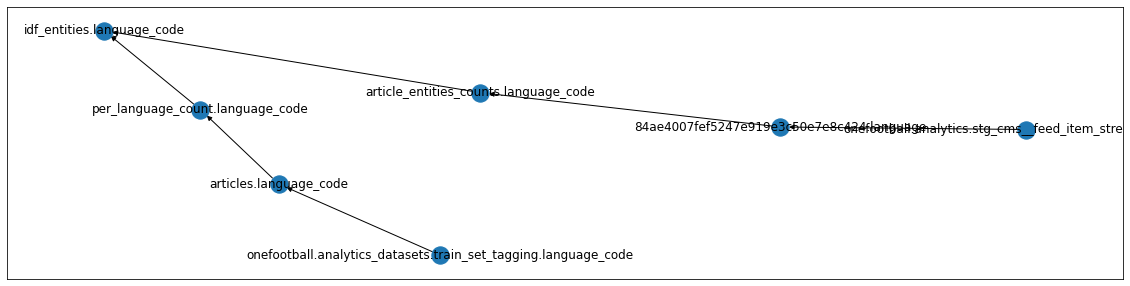

In [6]:
G = nx.DiGraph()
G.add_edges_from([(n1, n2) for n1, n2 in edges if nodes.get(n1) and nodes.get(n2)])

fig = draw_graph(G)

In [7]:
# Question: how to then bridge 2 different queries ?